In [2]:
import os

os.chdir("/home/sgsruan/UCL-gamma-ml/src")
print("Current working directory:", os.getcwd())

Current working directory: /home/sgsruan/UCL-gamma-ml/src


In [3]:
import data

In [4]:
root_dir = "/unix/erw/data/24-07-25/batch_output"
train_dataset, val_dataset, element_list, element_to_index = data.load_dataset(root_dir=root_dir, use_noise=True, val_ratio=0.2)

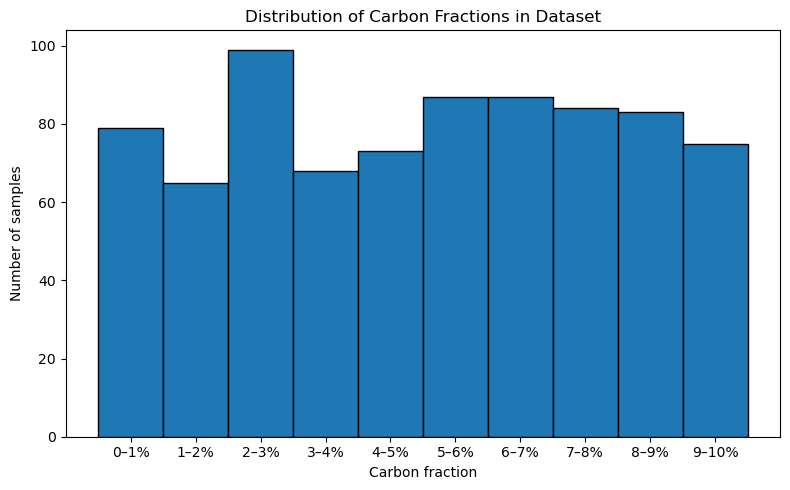

In [5]:
data.plot_carbon_fraction_histogram(train_dataset, element_to_index, bin_range='0-10')

### MLP+MDN

In [6]:
import models
import losses

In [7]:
# Hyperparameter
batch_size = 32
epochs = 20
learning_rate = 1e-4

In [8]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [8]:
# Initialize model
model = models.Dense_MDN(num_elements=3, num_mixtures=3)  # now we get more mixture components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/20 | Train Loss: 36.8548 | Val Loss: 36.0292
Epoch 2/20 | Train Loss: 33.8022 | Val Loss: 29.8511
Epoch 3/20 | Train Loss: 23.4171 | Val Loss: 13.8455
Epoch 4/20 | Train Loss: 9.1124 | Val Loss: 5.9236
Epoch 5/20 | Train Loss: 3.6552 | Val Loss: 1.9597
Epoch 6/20 | Train Loss: 0.1495 | Val Loss: -0.6270
Epoch 7/20 | Train Loss: -1.7721 | Val Loss: -1.9589
Epoch 8/20 | Train Loss: -2.5308 | Val Loss: -2.2196
Epoch 9/20 | Train Loss: -2.7359 | Val Loss: -2.4694
Epoch 10/20 | Train Loss: -2.7942 | Val Loss: -2.5221
Epoch 11/20 | Train Loss: -2.8532 | Val Loss: -2.4537
Epoch 12/20 | Train Loss: -2.8954 | Val Loss: -2.3240
Epoch 13/20 | Train Loss: -2.8567 | Val Loss: -2.4743
Epoch 14/20 | Train Loss: -2.9029 | Val Loss: -2.1192
Epoch 15/20 | Train Loss: -2.8580 | Val Loss: -2.4087
Epoch 16/20 | Train Loss: -2.9029 | Val Loss: -2.7113
Epoch 17/20 | Train Loss: -2.8977 | Val Loss: -2.5739
Epoch 18/20 | Train Loss: -2.9109 | Val Loss: -2.5748
Epoch 19/20 | Train Loss: -2.9197 | Val Lo

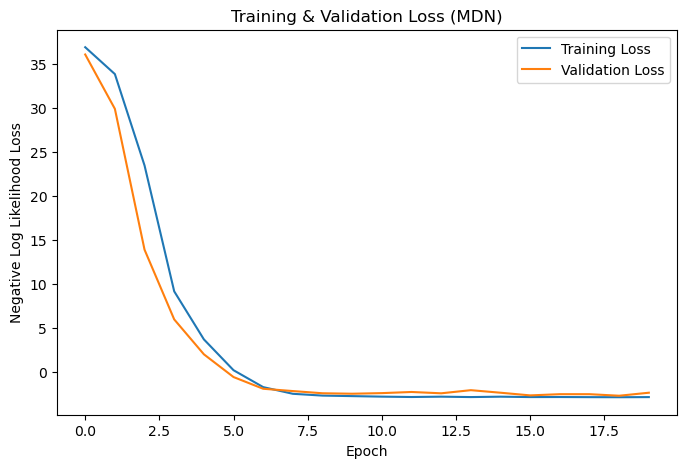

In [9]:
# Training loop
train_losses = []
val_losses = []

lr_switched_1 = False
lr_switched_2 = False
lr_switched_3 = False

gap_history = []
gap_window = 5
early_stop_triggered = False

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        pi, mu, sigma = model(batch_X)
        #sample_weights = compute_asymmetric_sample_weights(batch_Y).to(device)
        loss = losses.mdn_loss_std(batch_Y, pi, mu, sigma, alpha=5, eps=1e-6)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_Y in val_loader:
            val_X, val_Y = val_X.to(device), val_Y.to(device)
            pi, mu, sigma = model(val_X)
            #sample_weights = compute_asymmetric_sample_weights(val_Y).to(device)
            loss = losses.mdn_loss_std(val_Y, pi, mu, sigma, alpha=5, eps=1e-6, sample_weights=None)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood Loss")
plt.title("Training & Validation Loss (MDN)")
plt.legend()
plt.show()

In [31]:
import evaluation
import utils

In [11]:
results = evaluation.run_evaluation(model, val_loader, device, utils.mdn_predict_mean, utils.mdn_predict_std)

In [12]:
metrics = evaluation.metrics(results)
print(metrics)

{'MAE': 0.01796012558043003, 'NLL': -7.170643329620361}


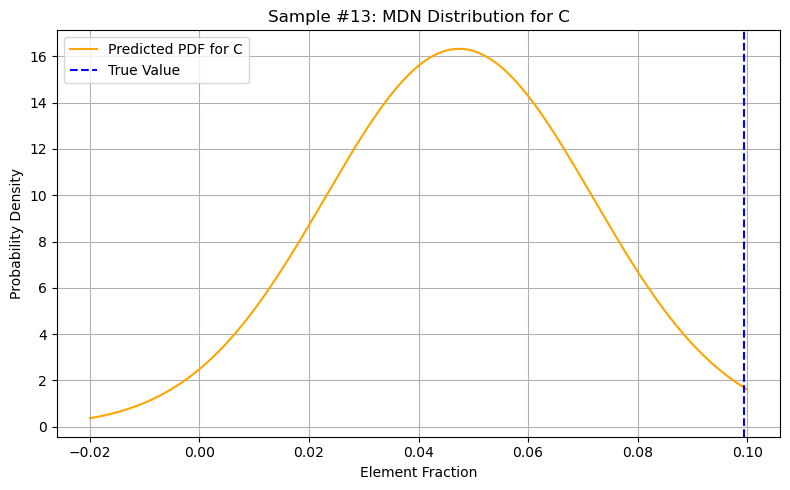

In [13]:
evaluation.plot_mdn_distribution(results, element_list, sample_index=13, element_name="C")

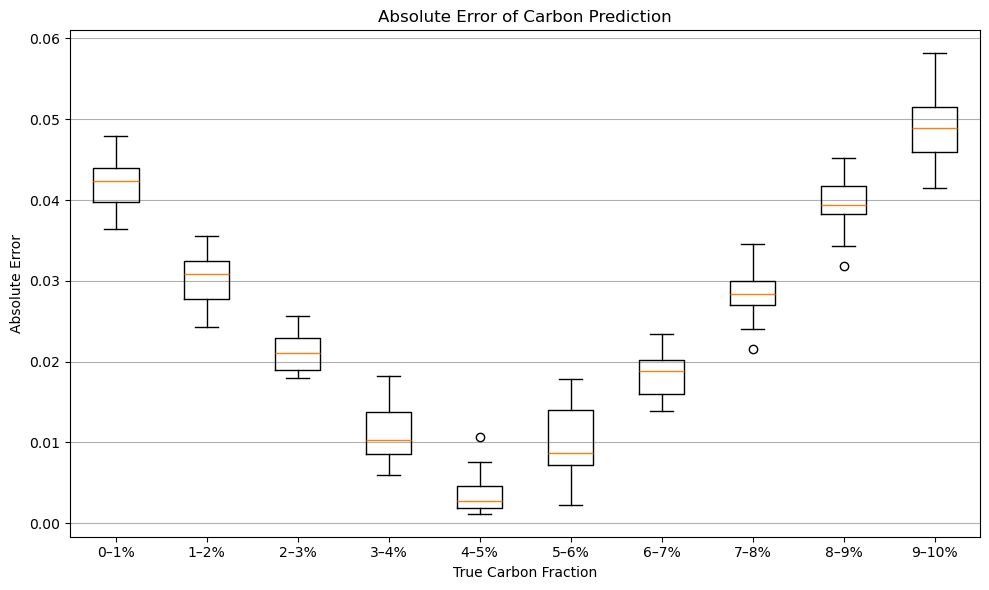

In [14]:
evaluation.plot_carbon_error_boxplot(results, element_to_index, bin_range="0-10")

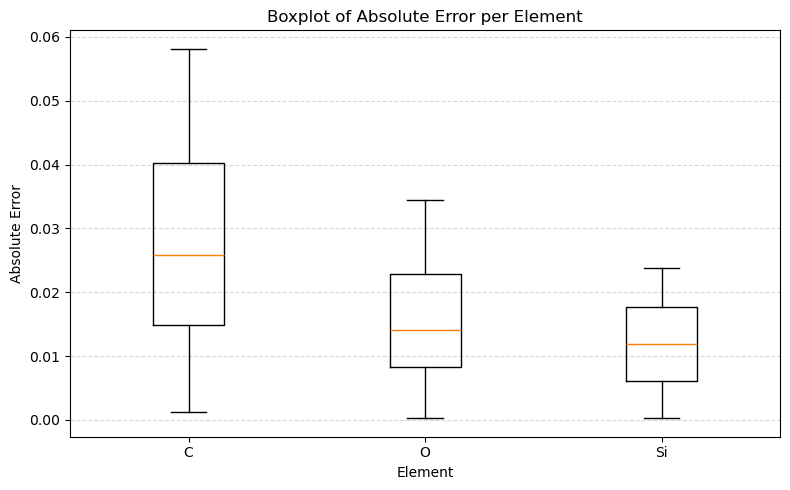

In [15]:
evaluation.plot_abs_error_boxplot(results, element_list)

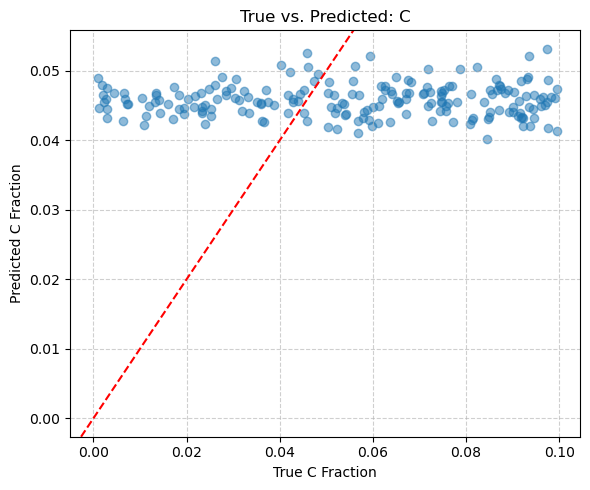

In [16]:
evaluation.plot_true_vs_pred_scatter(results, "C", element_to_index)

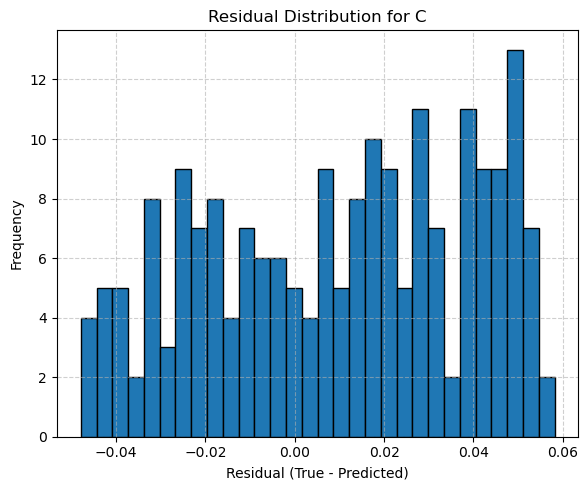

In [17]:
evaluation.plot_residual_histogram(results, "C", element_to_index, bins=30)

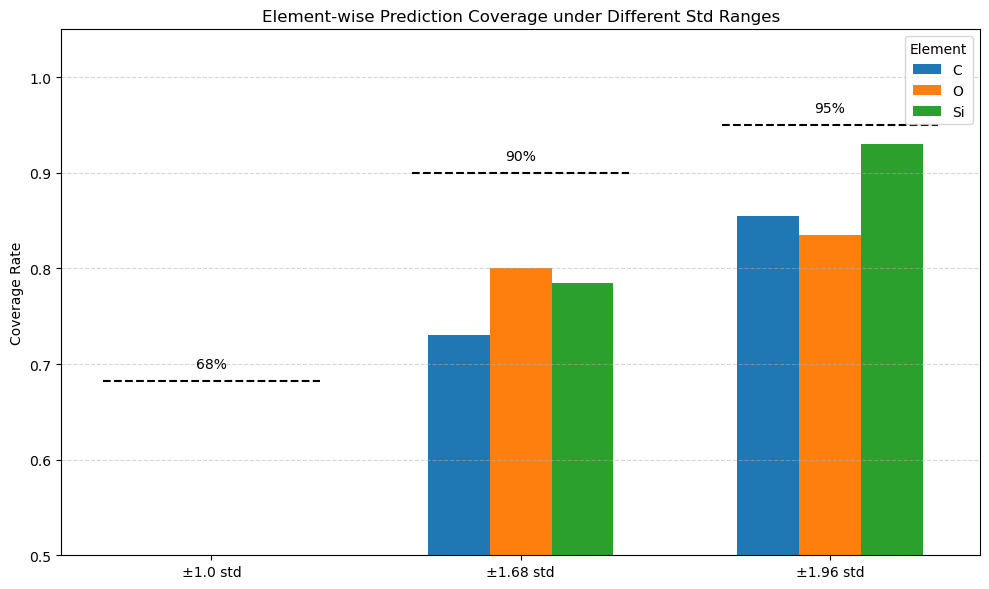

In [18]:
evaluation.plot_uncertainty_coverage(results, element_list, element_to_index)

### CNN-3conv-MDN

In [25]:
# Hyperparameter
batch_size = 32
epochs = 40
learning_rate = 1e-4

In [26]:
# Initialize model
model = models.deeper_CNN_MDN(num_elements=3, num_mixtures=3)  # now we get more mixture components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/40 | Train Loss: 22.7407 | Val Loss: 30.8271
Epoch 2/40 | Train Loss: 12.7180 | Val Loss: 20.0306
Epoch 3/40 | Train Loss: 7.0741 | Val Loss: 7.2616
Epoch 4/40 | Train Loss: 2.3725 | Val Loss: 1.0339
Switching learning rate to 5e-5
Epoch 5/40 | Train Loss: -1.1576 | Val Loss: -1.8444
Epoch 6/40 | Train Loss: -2.2645 | Val Loss: -2.4807
Switching learning rate to 1e-5
Epoch 7/40 | Train Loss: -2.8809 | Val Loss: -2.5196
Epoch 8/40 | Train Loss: -3.0412 | Val Loss: -2.6627
Epoch 9/40 | Train Loss: -3.1157 | Val Loss: -2.6849
Epoch 10/40 | Train Loss: -3.1885 | Val Loss: -2.7773
Epoch 11/40 | Train Loss: -3.2416 | Val Loss: -2.5726
Epoch 12/40 | Train Loss: -3.3224 | Val Loss: -2.8606
Epoch 13/40 | Train Loss: -3.4454 | Val Loss: -2.9217
Epoch 14/40 | Train Loss: -3.5302 | Val Loss: -2.9517
Epoch 15/40 | Train Loss: -3.6036 | Val Loss: -3.0340
Epoch 16/40 | Train Loss: -3.6909 | Val Loss: -3.2312
Epoch 17/40 | Train Loss: -3.7776 | Val Loss: -3.3132
Epoch 18/40 | Train Loss: -3.86

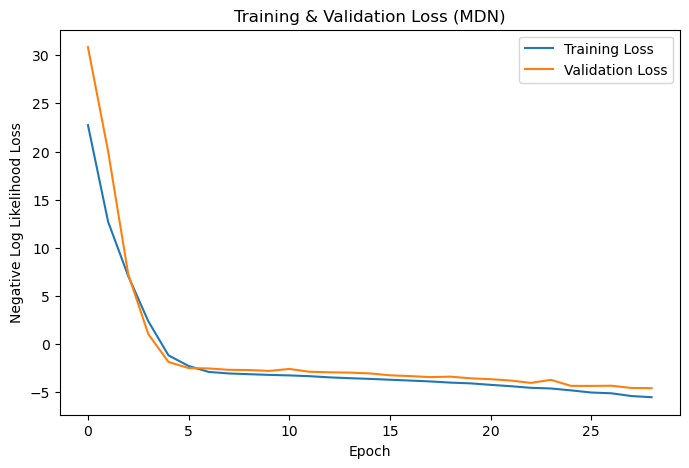

In [27]:
# Training loop
train_losses = []
val_losses = []

lr_switched_1 = False
lr_switched_2 = False
lr_switched_3 = False

gap_history = []
gap_window = 5
early_stop_triggered = False

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        pi, mu, sigma = model(batch_X)
        #sample_weights = compute_asymmetric_sample_weights(batch_Y).to(device)
        loss = losses.mdn_loss_std(batch_Y, pi, mu, sigma, eps=1e-6)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_Y in val_loader:
            val_X, val_Y = val_X.to(device), val_Y.to(device)
            pi, mu, sigma = model(val_X)
            #sample_weights = compute_asymmetric_sample_weights(val_Y).to(device)
            loss = losses.mdn_loss_std(val_Y, pi, mu, sigma, eps=1e-6)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    gap = avg_val_loss - avg_train_loss
    gap_history.append(gap)

    if len(gap_history) > gap_window:
        gap_history.pop(0)  # only keep N recent gap value

        if epoch >= 20 and avg_val_loss <= -4:  
            # If N recent gap strictly increasing
            if all(gap_history[i] < gap_history[i + 1] for i in range(gap_window - 1)):
                print(f"Early stop at {gap_window} epochs")
                early_stop_triggered = True
                break
    
    # Switch learning rate
    if not lr_switched_1 and avg_train_loss < 4:
        print("Switching learning rate to 5e-5")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 5e-5
        lr_switched_1 = True

    if not lr_switched_2 and avg_train_loss < -4:
        print("Switching learning rate to 1e-5")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-5
        lr_switched_2 = True

    if not lr_switched_3 and avg_train_loss < -6:
        print("Switching learning rate to 5e-6")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 5e-6
        lr_switched_3 = True

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood Loss")
plt.title("Training & Validation Loss (MDN)")
plt.legend()
plt.show()

In [28]:
results = evaluation.run_evaluation(model, val_loader, device, utils.mdn_predict_mean, utils.mdn_predict_std)

In [29]:
metrics = evaluation.metrics(results)
print(metrics)

{'MAE': 0.010631478391587734, 'NLL': -8.716802597045898}


### CNN-2conv-MDN

In [27]:
# Hyperparameter
batch_size = 32
epochs = 30
learning_rate = 1e-4

In [28]:
# Initialize model
model = models.deeper_CNN_MDN(num_elements=3, num_mixtures=3)  # now we get more mixture components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch 1/30 | Train Loss: 23.1738 | Val Loss: 29.9736
Epoch 2/30 | Train Loss: 7.8355 | Val Loss: 14.8663
Epoch 3/30 | Train Loss: 3.0637 | Val Loss: 4.1001
Switching learning rate to 5e-5
Epoch 4/30 | Train Loss: 0.2607 | Val Loss: -0.7845
Epoch 5/30 | Train Loss: -1.3132 | Val Loss: -0.4384
Epoch 6/30 | Train Loss: -1.9660 | Val Loss: -2.1673
Epoch 7/30 | Train Loss: -2.6591 | Val Loss: -2.9324
Epoch 8/30 | Train Loss: -3.1276 | Val Loss: -3.3914
Switching learning rate to 1e-5
Epoch 9/30 | Train Loss: -3.7663 | Val Loss: -3.6357
Epoch 10/30 | Train Loss: -3.9240 | Val Loss: -3.6666
Epoch 11/30 | Train Loss: -4.0520 | Val Loss: -3.7807
Epoch 12/30 | Train Loss: -4.1555 | Val Loss: -3.9214
Epoch 13/30 | Train Loss: -4.3404 | Val Loss: -3.9899
Epoch 14/30 | Train Loss: -4.4676 | Val Loss: -4.1546
Epoch 15/30 | Train Loss: -4.5817 | Val Loss: -4.2767
Epoch 16/30 | Train Loss: -4.7845 | Val Loss: -4.3155
Epoch 17/30 | Train Loss: -4.9225 | Val Loss: -4.5305
Epoch 18/30 | Train Loss: -5.19

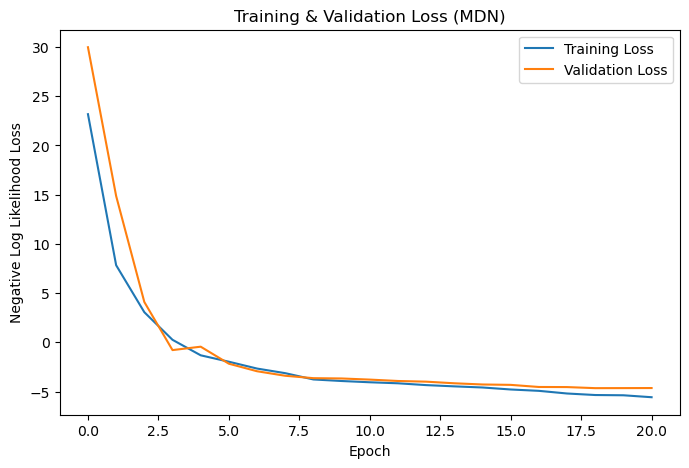

In [29]:
# Training loop
train_losses = []
val_losses = []

lr_switched_1 = False
lr_switched_2 = False
lr_switched_3 = False

gap_history = []
gap_window = 5
early_stop_triggered = False

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        pi, mu, sigma = model(batch_X)
        #sample_weights = compute_asymmetric_sample_weights(batch_Y).to(device)
        loss = losses.mdn_loss_std(batch_Y, pi, mu, sigma, eps=1e-6)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_Y in val_loader:
            val_X, val_Y = val_X.to(device), val_Y.to(device)
            pi, mu, sigma = model(val_X)
            #sample_weights = compute_asymmetric_sample_weights(val_Y).to(device)
            loss = losses.mdn_loss_std(val_Y, pi, mu, sigma, eps=1e-6)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    gap = avg_val_loss - avg_train_loss
    gap_history.append(gap)

    if len(gap_history) > gap_window:
        gap_history.pop(0)  # only keep N recent gap value

        if epoch >= 20 and avg_val_loss <= -4:  
            # If N recent gap strictly increasing
            if all(gap_history[i] < gap_history[i + 1] for i in range(gap_window - 1)):
                print(f"Early stop at {gap_window} epochs")
                early_stop_triggered = True
                break
    
    # Switch learning rate
    if not lr_switched_1 and avg_train_loss < 4:
        print("Switching learning rate to 5e-5")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 5e-5
        lr_switched_1 = True

    if not lr_switched_2 and avg_train_loss < -3:
        print("Switching learning rate to 1e-5")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-5
        lr_switched_2 = True

    if not lr_switched_3 and avg_train_loss < -5:
        print("Switching learning rate to 5e-6")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 5e-6
        lr_switched_3 = True

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood Loss")
plt.title("Training & Validation Loss (MDN)")
plt.legend()
plt.show()

In [32]:
results = evaluation.run_evaluation(model, val_loader, device, utils.mdn_predict_mean, utils.mdn_predict_std)

In [33]:
metrics = evaluation.metrics(results)
print(metrics)

{'MAE': 0.01034964993596077, 'NLL': -8.569313049316406}


### no-softmax

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_MDN_no_softmax(nn.Module):
    """ 1d-CNN + MDN model """
    def __init__(self, num_elements=3, num_mixtures=3):
        super().__init__()
        self.num_elements = num_elements  # D -- dimension of target vector
        self.num_mixtures = num_mixtures  # M -- number of Gaussian mixture components

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=9, padding=4),   # [B, 64, e.g.: 1440 (comes from spectrum)]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),                  # [B, 32, 360]

            nn.Conv1d(64, 128, kernel_size=7, padding=3), # [B, 128, 360]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # [B, 128, 180]
        )

        self.flatten_dim = 128 * 180  # update it if input structure changes

        self.hidden = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            #nn.Dropout(0.3),

            nn.Linear(256, 64),
            nn.ReLU(),
            #nn.Dropout(0.3),
        )

        # Output heads:
        self.pi_layer = nn.Linear(64, num_mixtures)                    # [B, M]
        self.mu_layer = nn.Linear(64, num_mixtures * num_elements)     # [B, M*D]
        self.sigma_layer = nn.Linear(64, num_mixtures * num_elements)  # [B, M*D]

    def forward(self, x):
        B = x.size(0)
        x = self.conv_layers(x)
        x = x.view(B, -1)
        x = self.hidden(x)

        # Output parameters : pi, mu, sigma
        pi = F.softmax(self.pi_layer(x), dim=1)  # [B, M]

        mu = self.mu_layer(x).view(B, self.num_mixtures, self.num_elements)  # [B, M, D]
        #mu = F.softmax(mu, dim=2)  # fraction (0~1, sum=1)

        sigma = torch.exp(self.sigma_layer(x).view(B, self.num_mixtures, self.num_elements))  # [B, M, D]

        return pi, mu, sigma

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_MDN_no_softmax(num_elements=3, num_mixtures=3).to(device)
model.load_state_dict(torch.load("../MDN_no_softmax.pt", map_location=device))

<All keys matched successfully>

In [72]:
model.eval()

all_preds = []
all_targets = []
all_stds = []

all_pi = []
all_mu = []
all_sigma = []

def nomarlize_mu(mu):
    mu_sum = mu.sum(dim=-1, keepdim=True)
    mu_sum = mu_sum + 1e-8     # avoid divide-by-zero
    mu_normalized = mu / mu_sum
    return mu_normalized

with torch.no_grad():
    for val_X, val_Y in val_loader:
        val_X = val_X.to(device)
        val_Y = val_Y.to(device)

        pi, mu, sigma = model(val_X)            # [B, M], [B, M, D], [B, M, D]
        mu = nomarlize_mu(mu)                   # normalization
        y_pred = utils.mdn_predict_mean(pi, mu)       # [B, D]
        y_std = utils.mdn_predict_std(pi, mu, sigma)  # [B, D]

        all_preds.append(y_pred.cpu())
        all_targets.append(val_Y.cpu())
        all_stds.append(y_std.cpu())

        all_pi.append(pi.cpu())
        all_mu.append(mu.cpu())
        all_sigma.append(sigma.cpu())


results = {
        "preds": torch.cat(all_preds, dim=0),
        "targets": torch.cat(all_targets, dim=0),
        "stds": torch.cat(all_stds, dim=0),
        "pi": torch.cat(all_pi, dim=0),
        "mu": torch.cat(all_mu, dim=0),
        "sigma": torch.cat(all_sigma, dim=0),
    }

In [73]:
metrics = evaluation.metrics(results)
print(metrics)

{'MAE': 0.0020398597698658705, 'NLL': -13.70211410522461}
